In [1]:
import sys
import torch

sys.path.insert(0, "..")
basedir = "../.."

from common.config import create_object, load_config

%matplotlib widget

torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

dconfig = load_config("../autoencoder/configs/data/dropletlincomb.yaml")
dconfig.datasize.spacedim = 1
dset = create_object(dconfig)

# wconfig = load_config("../autoencoder/configs/experiments/weldnormal.yaml")
# experiment = create_object(wconfig)

# wconfig = load_config("../autoencoder/configs/experiments/donnormal.yaml")
# experiment = create_object(wconfig)

# wpcaconfig = load_config("../autoencoder/configs/experiments/weldpca.yaml")
# wpcaconfig.windows = 3
# wpcaconfig.aeparams.reduced = 10
# pcaexperiment = create_object(wpcaconfig)

interactive(children=(IntSlider(value=0, description='t0', max=50), IntSlider(value=0, description='t1', max=5…

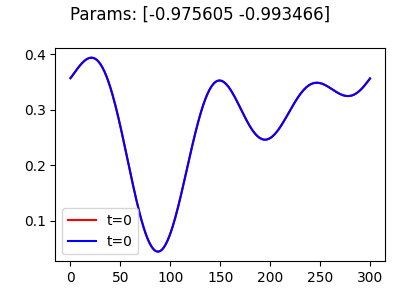

In [5]:
dset.plot_data(mode="params")

In [4]:
# Setup code

import sys
sys.path.insert(0, "..")
basedir = "../.."

import datetime
import skdim
import glob
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pickle
import re
import os
import ipywidgets as widgets

from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from torchdiffeq import odeint

import models
import utils

from models import WeldAnalyzer

%matplotlib widget
plt.rcParams["figure.figsize"] = (7, 4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dsets = [(f"{basedir}/datasets/burgers/grfarc2visc0p001-shift.mat", "grfarc2visc0p001"),
          (f"{basedir}/datasets/burgers/grfarc2visc0p001-scale.mat", "grfarc2visc0p001"),
          (f"{basedir}/datasets/transport/hats2_2500_shift.mat", "alldata"),
          (f"{basedir}/datasets/transport/hats2_2500_scale.mat", "alldata"),
          (f"{basedir}/datasets/kdv/kdv2-shift.mat", "kdv2wide"),
          (f"{basedir}/datasets/kdv/kdv2-scale.mat", "kdv2wide")]

names = ["bshift", "bscale", "tshift", "tscale", "kshift", "kscale"]

# dsets2d = [(f"{basedir}/datasets/transport/hats2d_shift.mat", "alldata"), 
#            (f"{basedir}/datasets/transport/hats2d_scale.mat", "alldata")]

# names2d = ["t2shift", "t2scale"]

# dsets = dsets2d
# names = names2d

In [5]:
dataset = utils.DynamicData((f"{basedir}/datasets/burgers2d/burgers2d_both_BIG.mat", "alldata"))

interactive(children=(IntSlider(value=0, description='t0', max=50), IntSlider(value=0, description='t1', max=5…

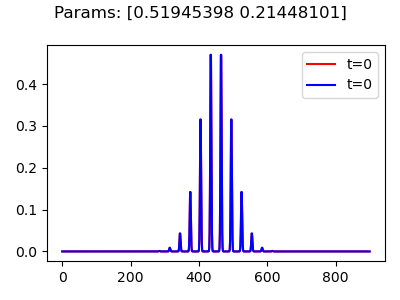

In [6]:
dataset.plot_data(mode="params")

In [7]:
dset = dsets[0]
dataset = utils.DynamicData(dset)
dataset.data.shape

KeyboardInterrupt: 

interactive(children=(IntSlider(value=1249, description='j', max=2499), IntSlider(value=0, description='t0', m…

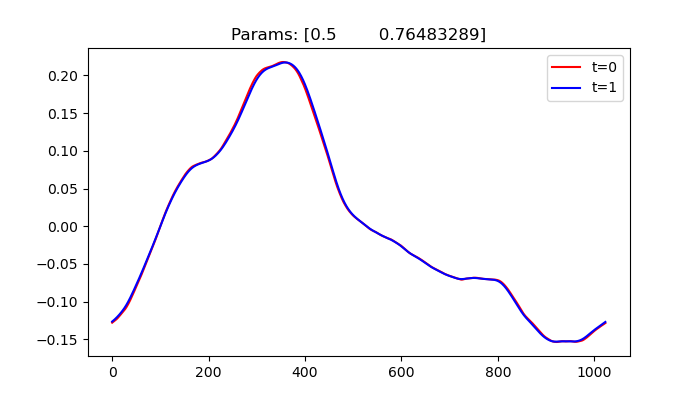

In [3]:
dataset.plot_data()

In [2]:
class WeldNetVF(models.WeldNet):
  # encodes, propagates, does NOT decode
  def propagate(self, arr, t, steps, arrencoded=False, method="euler"):
    assert(t + steps < self.T)

    w = self.find_window(t)
    input = torch.tensor(arr).to(self.device).float()

    if arrencoded:
      codes = input
    else:
      codes = self.encode_window(w, input)

    codeslist = []
    tremaining = max(steps, self.T - t - 1)
    tcurr = t
    while tremaining > 0:
      if tcurr > t:
        if len(self.transcoders) == 0:
          decoded = self.decode_window(w, codes)
          codes = self.encode_window(w+1, decoded)
          print(f"Default transcoding {w} to {w + 1} at time {tcurr}")
        else:
          ts = self.transcoders[w](codes)
          if self.residualprop:
            codes = codes + ts
          else:
            codes = ts

          print(f"Explicit transcoding {w} to {w + 1} at time {tcurr}")

        w = w + 1
      
      increment = min(self.windowvals[w][-1] - tcurr, tremaining)
      t_span = torch.tensor(range(tcurr, tcurr + increment + 1)).to(device).float()

      codes = odeint(self.props[w], codes, t_span, method=method)

      tcurr += increment
      tremaining -= increment
      codeslist = codeslist + ([codes[i] for i in range(codes.shape[0])])

    return codeslist

  def prop_epoch(self, w, dataloader, writer=None, optimizer=None, ep=0, printinterval=10, loss=None, testtensor=None, method="euler"):
    vf = self.props[w]

    losses = []
    testerrors1 = []
    testerrors2 = []
    testerrorsinf = []
    
    def closure(batch):
      B, T, K = batch.shape
      optimizer.zero_grad()

      #cumulative loss
      initial = batch[:, 0, :].to(device).float()

      tspan = torch.tensor(range(self.windowvals[w][0], self.windowvals[w][-1] + 1)).to(device).float()
      trajectory = odeint(vf, initial, tspan, method=method).transpose(0, 1)

      trajectory = trajectory.reshape(B*T, K)
      batch = batch.reshape(B*T, K)
      lossval = loss(trajectory, batch)

      #tspan = [0, 1]
      #trajectory = odeint(self.vf, batch, tspan, method='')

      if writer is not None:
        if self.propstep % 5 == 0:
          writer.add_scalar("propagator/loss", lossval, global_step=self.propstep)

      lossval.backward()
      return lossval

    half = int(testtensor.shape[1] / 2)
    for batch in dataloader:
      self.propstep += 1
      batch = batch.to(self.device)

      error = optimizer.step(lambda: closure(batch))
      losses.append(float(error.cpu().detach()))

    # print test
    if printinterval > 0 and (ep % printinterval == 0):
      testinputs = testtensor[:, 0, :]
      testoutputs = testtensor[:, -1, :].cpu().detach().numpy()

      t0 = self.windowvals[w][0]
      t1 = self.windowvals[w][-1]
      predict = self.propagate(testinputs, t0, t1-t0, arrencoded=True)[-1].cpu().detach().numpy()

      testerr1 = np.mean(np.linalg.norm(predict - testoutputs, axis=1, ord=1) / np.linalg.norm(testoutputs, axis=1, ord=1))
      testerr2 = np.mean(np.linalg.norm(predict - testoutputs, axis=1, ord=2) / np.linalg.norm(testoutputs, axis=1, ord=2))
      testerrinf = np.mean(np.linalg.norm(predict - testoutputs, axis=1, ord=np.inf) / np.linalg.norm(testoutputs, axis=1, ord=np.inf))

      testerrors1.append(testerr1)
      testerrors2.append(testerr2)
      testerrorsinf.append(testerrinf)
      
      print(f"{ep+1}: Train Loss {error:.3e}, Relative Test Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")

      if writer is not None:
          writer.add_scalar("misc/relativeL1prop", testerr1, global_step=ep)
          writer.add_scalar("main/relativeL2prop", testerr2, global_step=ep)
          writer.add_scalar("misc/relativeLInfprop", testerrinf, global_step=ep)

    return losses, testerrors1, testerrors2, testerrorsinf

  def train_propagators(self, epochs, save=True, optim=torch.optim.AdamW, lr=1e-4, printinterval=10, batch=32, ridge=0, loss=None, encoding_param=-1, best=True, verbose=False, method="euler"):
    if loss is None:
      loss = nn.MSELoss()
    else:
      loss = loss()

    if encoding_param == -1:
      encoding_param = []
      P = self.dataset.params.shape[1]

      for p in range(P):
        if np.abs(self.dataset.params[0, p] - self.dataset.params[1, p]) > 0:
          encoding_param.append(p)

    losses_all, testerrors1_all, testerrors2_all, testerrorsinf_all = [], [], [], []
    for w in range(self.W):
      prop = self.props[w]
      opt = optim(prop.parameters(), lr=lr, weight_decay=ridge)

      losses, testerrors1, testerrors2, testerrorsinf = [], [], [], []
      bestdict = { "loss": float(np.inf), "ep": 0 }

      self.propstep = 0

      data = torch.tensor(self.trains[w], dtype=torch.float, device=self.device)
      datatest = torch.tensor(self.tests[w], dtype=torch.float, device=self.device)
      
      projected = self.aes[w].encode(torch.tensor(data).to(self.device).float()).detach()
      projectedTest = self.aes[w].encode(torch.tensor(datatest).to(self.device).float()).detach()

      numtrain = int(projected.shape[0] * 0.8)
      train = projected[:numtrain, :, :]
      test = projected[numtrain:, :, :]
      dataloader = torch.utils.data.DataLoader(train, shuffle=False, batch_size=batch)
      writer = None
      
      if self.td is not None:
          name = f"./tensorboard/{datetime.datetime.now().strftime('%d-%B-%Y')}/{self.td}-weldprop{w}/{datetime.datetime.now().strftime('%H.%M.%S')}/"
          writer = torch.utils.tensorboard.SummaryWriter(name)
          print("Tensorboard writer location is " + name)

      print("Number of NN trainable parameters", utils.num_params(prop))
      print(f"Starting training prop {w+1}/{self.W} at {time.asctime()}...")
      print("train", projected.shape, "test", projectedTest.shape)

      self.propstep = 0
      for ep in range(epochs):
          lossesN, testerrors1N, testerrors2N, testerrorsinfN = self.prop_epoch(w, dataloader, optimizer=opt, writer=writer, ep=ep, printinterval=printinterval, loss=loss, testtensor=projectedTest, method=method)
          losses += lossesN; testerrors1 += testerrors1N; testerrors2 += testerrors2N; testerrorsinf += testerrorsinfN

          if best and ep > epochs // 2:
            avgloss = np.mean(lossesN)
            if avgloss < bestdict["loss"]:
              bestdict["model"] = self.props[w].state_dict()
              bestdict["opt"] = opt.state_dict()
              bestdict["loss"] = avgloss
              bestdict["ep"] = ep
            elif verbose:
              print(f"Loss not improved at epoch {ep} (Ratio: {avgloss/bestdict['loss']:.2f}) from {bestdict['ep']} (Loss: {bestdict['loss']:.2e})")
      
      print(f"Finish training propagator {w+1} at {time.asctime()}.")
      losses_all += losses; testerrors1_all += testerrors1; testerrors2_all += testerrors2; testerrorsinf_all += testerrorsinf

    print("Finished training all propagators")

    if save:
      dire = "savedmodels/weld/props"
      addr = f"{dire}/{self.td}{self.W}w-props-{datetime.datetime.now().strftime('%d-%B-%Y-%H.%M')}.pickle"

      if not os.path.exists(dire):
        os.makedirs(dire)

      with open(addr, "wb") as handle:
        pickle.dump({"props": self.props, "propdata": self.propdata, "datadata": self.datadata, "aedata": self.aedata, "aes": self.aes}, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Propagators saved at", addr)

    return { "losses": losses, "testerrors1": testerrors1, "testerrors2": testerrors2, "testerrorsinf": testerrorsinf}
  
class TrajectoryVF(nn.Module):
  def __init__(self, seq, activation):
      super().__init__()

      self.layers = nn.ModuleList([nn.Linear(seq[i], seq[i+1]) for i in range(len(seq) - 1)])
      self.s = activation

      if seq[0] == seq[-1]:
          self.autonomous = True
      elif seq[0] == seq[-1] + 1:
          self.autonomous = False
      else:
          assert(False)

  def forward(self, t, x):
      if not self.autonomous:
          tvec = torch.ones((x.shape[0], 1)) * t
          x = torch.column_stack((x, tvec))

      for i, layer in enumerate(self.layers):
          x = layer(x)
          if not i == len(self.layers) - 1:
              x = self.s(x)      
                      
      return x

In [15]:
baseepochs = 100
trainer = WeldNetVF

aeclass = models.FFAutoencoder
propclass = models.FFNet
transclass = models.FFNet

if trainer == WeldNetVF:
  propclass = TrajectoryVF

welds = {}
start = 0
end = 1
for dset, name in zip(dsets[start:end], names[start:end]):
  dataset = utils.DynamicData(dset)
  print(dset, name)

  dataset.shuffle_inplace()
  dataset.subset_data(500)
  dataset.downsample(int(dataset.data.shape[2] / 512))
  #dataset.data = dataset.data[:, ::2]
  dataset.scaledown()

  din = dataset.data.shape[-1]
  Lae = 3
  Lprop = 3
  pae = 500
  pprop = 300
  rp = True
  trans = True

  welds[name] = []

  for k in [2]:
    for style in ["base"]:
      for w in [1]:
        for auton in [True]:
          aeargs = { "encodeSeq": [din] + [pae] * Lae + [k], "decodeSeq": [k] + [pae] * Lae + [din], "activation": "relu" }
          propargs = { "seq": [k if auton else k+1] + [pprop] * Lprop + [k], "activation": "relu" }
          transargs = { "seq": [k] + [pprop] * Lprop + [k], "activation": "relu" } if trans else None

          transclass_curr = transclass
          if not trans:
            transclass_curr = None

          if style == "base":
            weld = trainer(dataset, w, aeclass, aeargs, propclass, propargs, transclass_curr, transargs, overlapnum=1, device=device, tensorboard_directory=f"{name}base-{k}-{'auton' if auton else 'nonauton'}", straightness=0, autonomous=auton, residualprop=rp)
          elif style == "straight":
            weld = trainer(dataset, w, aeclass, aeargs, propclass, propargs, transclass_curr, transargs, overlapnum=1, device=device, tensorboard_directory=f"{name}straight-{k}-{'auton' if auton else 'nonauton'}", straightness=0.1, autonomous=auton, residualprop=rp)
          else:
            weld = trainer(dataset, w, aeclass, aeargs, propclass, propargs, transclass_curr, transargs, overlapnum=1, device=device, tensorboard_directory=f"{name}kinetic-{k}-{'auton' if auton else 'nonauton'}", kinetic=10, autonomous=auton, residualprop=rp)

          loadall = weld.load_all(name, transcoders=trans)
          
          if not loadall:
            loadae = weld.load_aes(name)
            if not loadae:
              weld.train_aes(baseepochs, warmstart_epochs=baseepochs, printinterval=25, batch=16, save=True, plottb=False, lr=1e-4)

            weld.train_propagators(baseepochs, batch=32, printinterval=10, save=False, lr=1e-4)

            if trans:
              if w > 1:
                loadtrans = weld.load_transcoders(name)
                if not loadtrans:
                  weld.train_transcoders(baseepochs * 5, printinterval=baseepochs//2, lr=1e-4, save=True)

          welds[name].append(weld)

('../../datasets/burgers/grfarc2visc0p001-shift.mat', 'grfarc2visc0p001') bshift
Propagator failed. Could not match with any files
['savedmodels/weld/props\\bshiftbase-4-auton1w-props-04-September-2024-14.32.pickle', 'savedmodels/weld/props\\bshiftbase-4-auton1w-props-14-August-2024-13.41.pickle', 'savedmodels/weld/props\\bshiftbase-4-auton1w-props-14-August-2024-13.42.pickle', 'savedmodels/weld/props\\bshiftbase-4-nonauton1w-props-14-August-2024-20.28.pickle', 'savedmodels/weld/props\\bshiftkinetic-4-auton1w-props-14-August-2024-20.31.pickle', 'savedmodels/weld/props\\bshiftkinetic-4-nonauton1w-props-14-August-2024-20.32.pickle', 'savedmodels/weld/props\\bshiftstraight-4-auton1w-props-14-August-2024-20.29.pickle', 'savedmodels/weld/props\\bshiftstraight-4-nonauton1w-props-14-August-2024-20.30.pickle']
Searching for [<class 'models.FFAutoencoder'>, {'encodeSeq': [512, 500, 500, 500, 2], 'decodeSeq': [2, 500, 500, 500, 512], 'activation': ReLU()}, 1, 0, 0] [0.0006149896516944864, (500, 

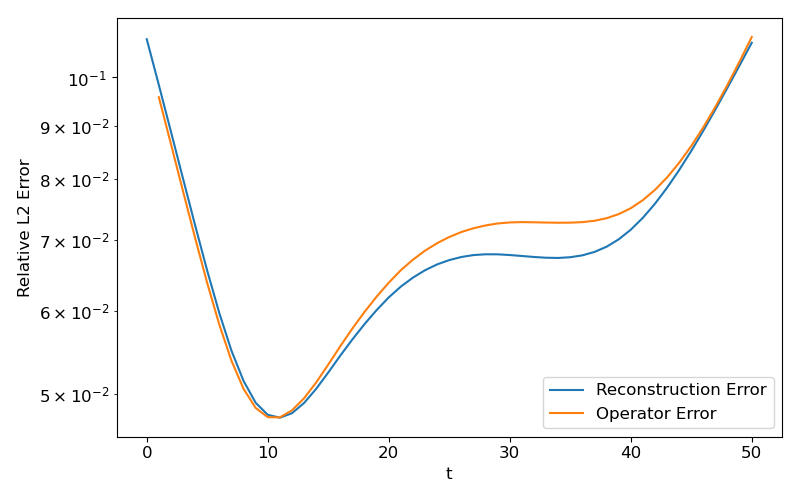

In [18]:
WeldAnalyzer.plot_projops(weld)

In [4]:
def sample_vf(vf, x, T, t0=0, t1=1, plot=True, method="euler"):
    t_span = torch.linspace(t0, t1, T+1)
    out = odeint(vf, x, t_span, method=method).cpu().detach().numpy()

    if plot:
        fig, ax = plt.subplots()

        for i in range(out.shape[0]):
            ax.scatter(out[i, :, 0], out[i, :, 1], label=i)

        ax.legend()

        return fig
    else:
        return out

def quiver_vf(weld, w, n=21, xs=(0, 1), ys=(0, 1), scale=1, times=None):
    vf = weld.props[w]

    x = np.linspace(xs[0], xs[1], n)
    y = np.linspace(ys[0], ys[1], n)
    grid_x, grid_y = np.meshgrid(x, y)

    grid = np.array([grid_x.flatten(), grid_y.flatten()]).T
    vecs = vf(0, torch.tensor(grid).float()).cpu().detach().numpy()

    if times is not None:
        fig = WeldAnalyzer.plot_encoding_time(weld, ts=times)
        ax = fig.axes[0]
    else:
        fig, ax = plt.subplots(figsize=(8, 6))

    sc = ax.quiver(grid[:, 0], grid[:, 1], vecs[:, 0], vecs[:, 1], np.linalg.norm(vecs, axis=1), cmap="winter", angles="xy", scale=scale, units="xy")
    plt.colorbar(sc, ax=ax)
    fig.axes[1].set_title("Length")

    return fig

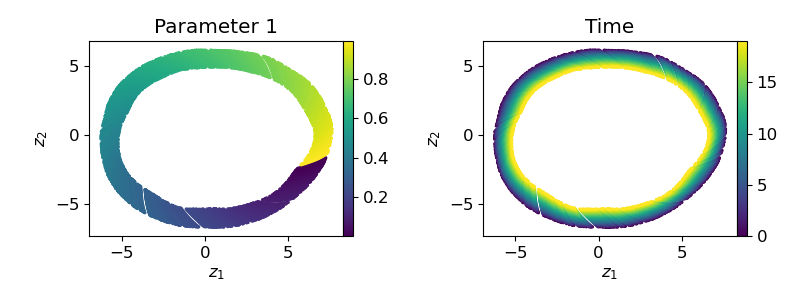

In [19]:
WeldAnalyzer.plot_encoding_window(weld, 0)

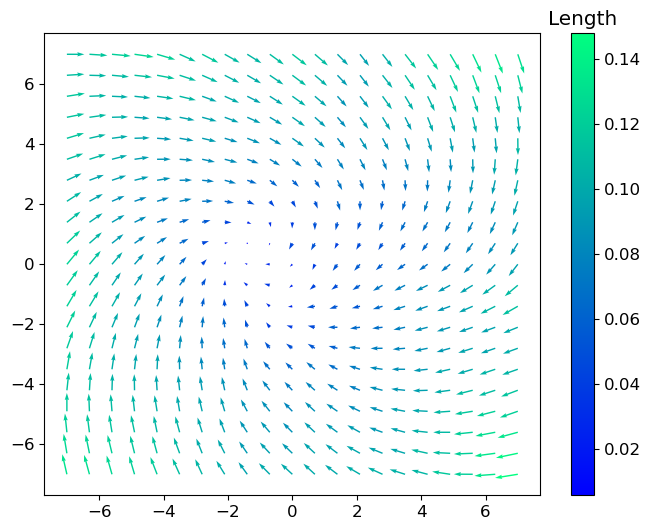

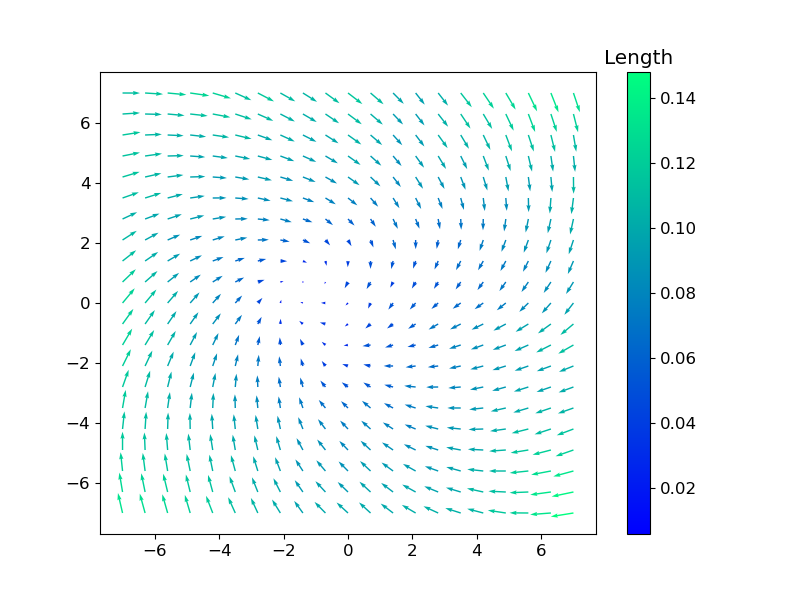

In [20]:
quiver_vf(weld, 0, xs=(-7, 7), ys=(-7, 7), scale=0.2)